# Imports

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import urban_module as ubm
from geomedian_training_step_1_functions import *

# Main

In [3]:
# Path to unsupervised clustering output
path='/g/data/u46/pjt554/urban_geomedian_data/canberra/2018'

path_out = '/g/data/u46/users/sc0554/LCCS/urban-extents'

### BELOW VARIABLE IS UNUSED ###
# Path to model 
# modeldirc= '/g/data1/u46/pjt554/urban_extent_s2'

# List of features
featurelist=['TSC_BRI', 'MSAVI', 'MNDWI', 'NDVI', 'NDTI', 'DBSI', 'BUI', 'SAVI', 
              'VAUI', 'NDWI','MVAUI', 'WVAUI', 'BSI']#, 'vv_mean','vv_std', 'vv_range','vh_mean', 'vh_std','vh_range']

In [4]:
datastack=[]

sbm=len(featurelist)
print(sbm)

# For each feature load the dataset and append it to a list
for name in featurelist:
    h, oneband, pnum = ubm.load_envi_data_float(path, name)
    #TODO: Assess why this indexing is neccessary
    oneband=oneband[0]
    datastack.append(oneband)
    
print(datastack[0].shape)

13
(2241176,)


In [5]:
# Load the clustering output file
#TODO: This workflow of creating empty arrays to fill with the loaded data could be replaced with a simply numpy load
filename='urban_spec_5c'
h, clsarr, pnum = ubm.load_envi_data_char(path, filename)
clsarr=clsarr[0]
oneimg=np.zeros((sbm, pnum), dtype=np.float32)
for i in np.arange(sbm):
    oneimg[i, :]=datastack[i]

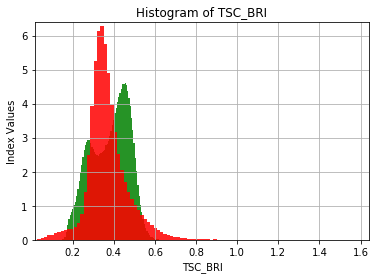

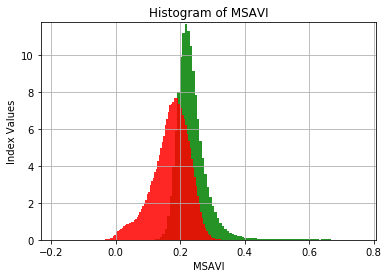

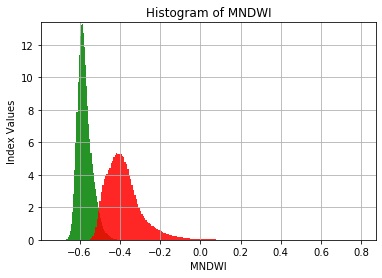

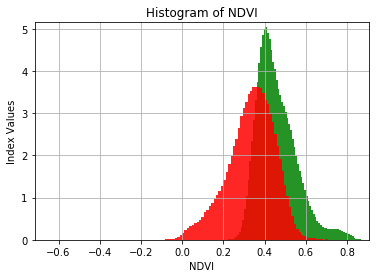

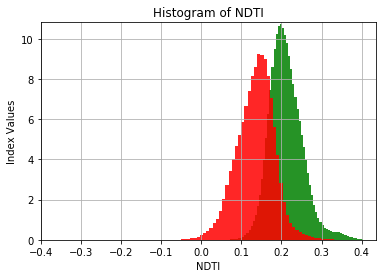

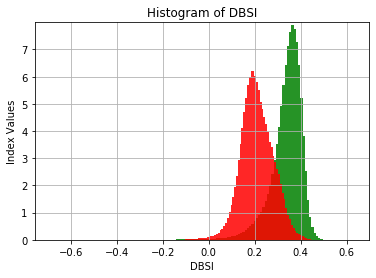

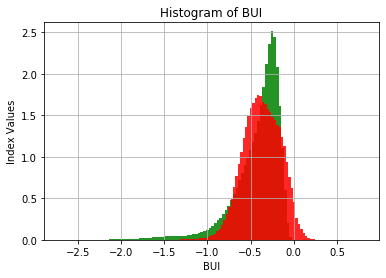

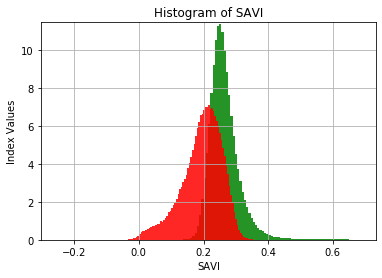

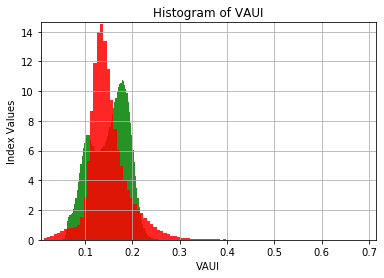

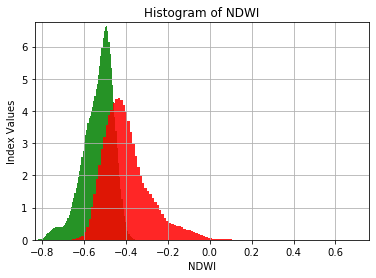

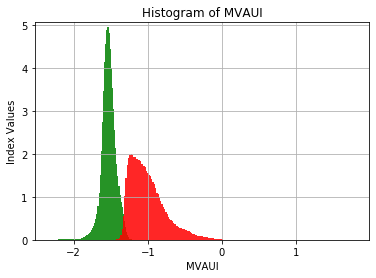

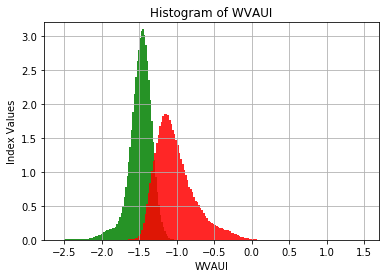

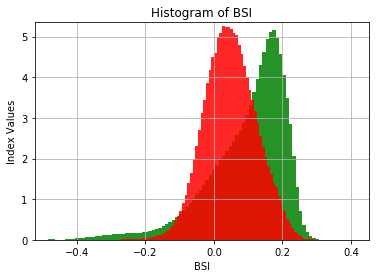

In [6]:
# Plot histograms to check each feature's seperation of vegetation and urban / bare
num_bins=100
for tgtband in featurelist:
    ubm.draw_index_hist(tgtband, featurelist, oneimg, clsarr, num_bins)

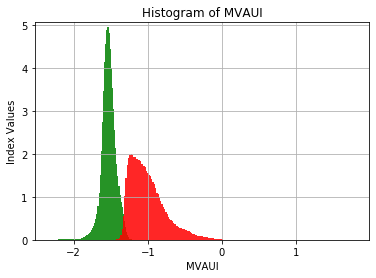

In [7]:
# Plot feature with best seperation
tgtband='MVAUI'
num_bins=100
ubm.draw_index_hist(tgtband, featurelist, oneimg, clsarr, num_bins)

In [8]:
# Number of classes
numcls=4
# distarr is the number of occurences of each class within each bin
bounds, distarr, pidxlist = hist_distribution(tgtband, featurelist, oneimg, clsarr, numcls, num_bins)
# Calculate the entropy for each bin
enp = bin_entropy(distarr, 1, 3, num_bins)

In [9]:
# c1 refers to class 1 (green pixels / vegetation)
# c2 refers to class 2 (urban pixels)
# thd refers to threshold
thd=0.03
c1=1
c2=3
c1_train, c2_train = create_training_sets(enp, thd, pidxlist, distarr, clsarr, num_bins, c1, c2)

In [10]:
# Seperate out green and urban pixels
gre_pixels = conclistarr(c1_train)
urb_pixels = conclistarr(c2_train)
ds=min(gre_pixels.shape[0], urb_pixels.shape[0])

In [11]:
# This was enforced as Peter doesn't think that the maximum amount of training data is neccessary for a succesful model in this instance
if (ds>50000):
    ds=50000

In [12]:
# populate array with training data

allbands=['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

bm=len(allbands)
inputdata=np.zeros((pnum, bm), dtype=np.float32)

for cc, bandname in enumerate(allbands):
    filename=path+'/NBAR_'+bandname+'.img'
    banddata=np.fromfile(filename, dtype=np.float32)
    inputdata[:, cc]=banddata

In [13]:
for cc, bandname in enumerate(allbands):
    print(cc, bandname)

0 blue
1 green
2 red
3 nir
4 swir1
5 swir2


In [14]:
# Create train and test sets
#TODO: maybe implement this using the SKlearn train and test splitter
c1_tra_num=int(ds*.8)
c1_tst_num=int(ds*.2)
c2_tra_num=c1_tra_num
c2_tst_num=c1_tst_num

In [15]:
create_sets(featurelist, inputdata, gre_pixels, c1_tra_num, c1_tst_num, urb_pixels, c2_tra_num, c2_tst_num, 
                 'veg_urb', path_out)